## Guessing colourmaps with Markov chains

#### by ARI HARTIKAINEN

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from scipy import signal

# Set-up the problem files

In [3]:
nx, ny = 100, 100
rng = np.random.RandomState(seed=24)
z = rng.rand(nx, ny)

sizex, sizey = 30, 30
x, y = np.mgrid[-sizex:sizex+1, -sizey:sizey+1]
g = np.exp(-0.333*(x**2/float(sizex)+y**2/float(sizey)))
f = g/g.sum()

z = signal.convolve(z, f, mode='valid')
z = (z - z.min())/(z.max() - z.min())

In [4]:
cmap = 'viridis'    # Perceptual
cmap = 'spectral'   # Classic rainbow
cmap = 'seismic'    # Classic diverging
cmap = 'Accent'     # Needs coolinearity constraint
cmap = 'Dark2'      # Needs coolinearity constraint
cmap = 'Paired'     # Needs coolinearity constraint, ultimate test!
cmap = 'gist_ncar'  # Works with new cool-point start location
cmap = 'Pastel1'    # Amazing that it works for start point
cmap = 'Set2'       # Difficult

#cmap = 'Dark2'

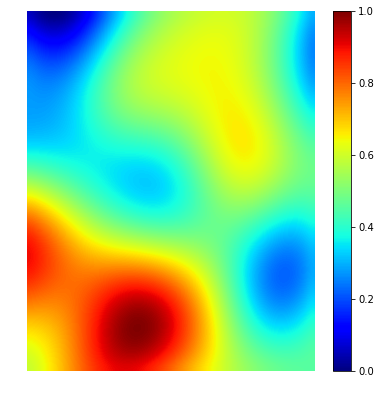

In [5]:
fig = plt.figure(frameon=False)
fig.set_size_inches(5,5)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

# Note: interpolation introduces new colours.
plt.imshow(z, cmap="jet", aspect='auto', interpolation="bicubic")
#plt.imshow(z, cmap=cmap, interpolation='none')
fig.savefig('test2.png', dpi=100)
plt.colorbar()

In [6]:
z.shape

(40, 40)

In [7]:
cmaps = [('Perceptually Uniform Sequential',
                            ['viridis', 'inferno', 'plasma', 'magma']),
         ('Sequential',     ['Blues', 'BuGn', 'BuPu',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']),
         ('Sequential (2)', ['afmhot', 'autumn', 'bone', 'cool',
                             'copper', 'gist_heat', 'gray', 'hot',
                             'pink', 'spring', 'summer', 'winter']),
         ('Diverging',      ['BrBG', 'bwr', 'coolwarm', 'PiYG', 'PRGn', 'PuOr',
                             'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 'Spectral',
                             'seismic']),
         ('Qualitative',    ['Accent', 'Dark2', 'Paired', 'Pastel1',
                             'Pastel2', 'Set1', 'Set2', 'Set3']),
         ('Miscellaneous',  ['gist_earth', 'terrain', 'ocean', 'gist_stern',
                             'brg', 'CMRmap', 'cubehelix',
                             'gnuplot', 'gnuplot2', 'gist_ncar',
                             'nipy_spectral', 'jet', 'rainbow',
                             'gist_rainbow', 'hsv', 'flag', 'prism'])]

# Problem solving starts here

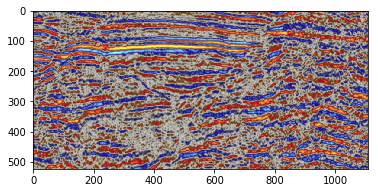

In [19]:
#img = plt.imread('test2.png')
img = plt.imread('petrel-seismic.png')
plt.imshow(img)

Remove alpha.

In [20]:
img = img[..., :-1]

## Find all the unique color tuples

In [21]:
# For more robust results I think blurring image first could be good idea
# This is assuming that autocorrelation is approximately the same as without blurring

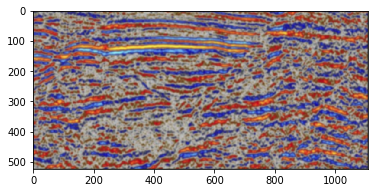

In [22]:
import scipy.signal
import scipy.ndimage
import bruges

kernel = bruges.filters.gaussian_kernel(size=8)
img = scipy.signal.fftconvolve(img, kernel[:, :, None], mode='same')
plt.imshow(img)

In [23]:
unique_colors = set()
for c in img.reshape(-1, 3):
    unique_colors.add(tuple(c))

# Some convenience dictionaries
# color tuple to id
unique_colors = {c : i for i, c in enumerate(unique_colors)}
# id to color tuple
unique_colors_reverse = {val : key for key, val in unique_colors.items()}
len(unique_colors)

581116

## Reduce colors

In [24]:
np.any(img > 1)

False

In [25]:
img[img > 1] = 1
img[img < 0] = 0

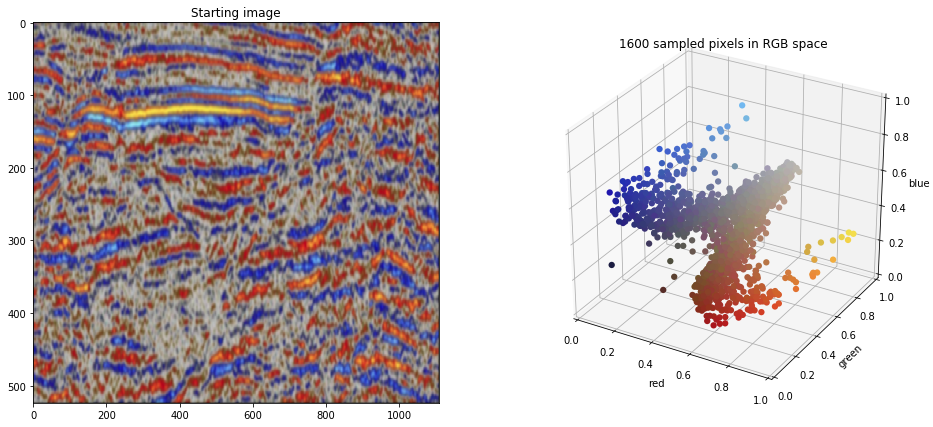

In [26]:
n_colours = 16

from sklearn.cluster import KMeans
from sklearn.utils import shuffle

h, w, d = img.shape
im = img.reshape((w * h, d))

# Define training set: 100 times n_colours, up to 10% of the image.
n = min(h*w//10, n_colours*100)
sample = shuffle(im, random_state=0)[:n]
px = sample.reshape((-1, sample.shape[-1]))

from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(16, 7))

ax0 = fig.add_subplot(121)
plt.imshow(img, interpolation='none', aspect='auto')
ax0.set_title("Starting image")

ax = fig.add_subplot(122, projection='3d')
ax.scatter(*px.T, c=px, lw=0, s=40, alpha=1)
ax.set_title('{} sampled pixels in RGB space'.format(n))
ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

plt.savefig('image_and_colourmap.png', bbox_inches='tight', dpi=300)
plt.show()

In [27]:
kmeans = KMeans(n_clusters=n_colours).fit(px)

p = kmeans.cluster_centers_

# I shouldn't need to do this, but I do. Floating point precision maybe.
# p[p > 1] = 1
# p[p < 0] = 0

In [28]:
labels = kmeans.predict(im)

img_ = p[labels].reshape((h, w, 3))

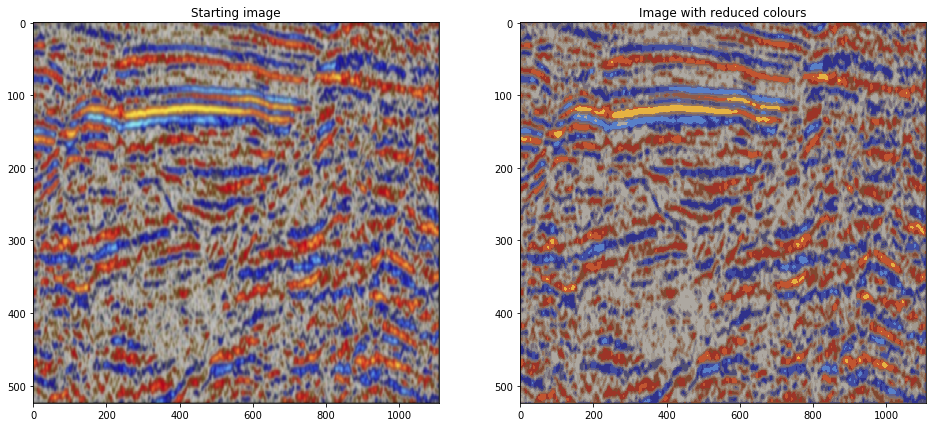

In [29]:
fig = plt.figure(figsize=(16, 7))

ax0 = fig.add_subplot(121)
plt.imshow(img, interpolation='none', aspect='auto')
ax0.set_title("Starting image")

ax1 = fig.add_subplot(122)
plt.imshow(img_, aspect='auto')
ax1.set_title("Image with reduced colours")

plt.show()

In [30]:
unique_colors = set()
for c in img_.reshape(-1, 3):
    unique_colors.add(tuple(c))

# Some convenience dictionaries
# color tuple to id
unique_colors = {c : i for i, c in enumerate(unique_colors)}
# id to color tuple
unique_colors_reverse = {val : key for key, val in unique_colors.items()}
len(unique_colors)

16

In [31]:
from collections import defaultdict

In [47]:
# Iterate through top, bottom, left and right 
# This makes Markov matrix symmetric

from tqdm import tqdm

# Save counts to dict of dicts
differences = {"top" : defaultdict(lambda: defaultdict(int)),
               "bottom" : defaultdict(lambda: defaultdict(int)),
               "left" : defaultdict(lambda: defaultdict(int)),
               "right" : defaultdict(lambda: defaultdict(int)),
              }

# Iterate through all cells and check pixel pairs --> update pair counts ""(from - to) -pair"
rows, cols = img_.shape[:2]
for row in tqdm(range(0, rows, 3)):
    for col in range(0, cols, 3):
        # main cell
        cval = unique_colors[tuple(img_[row, col])]
        
        # current-top -pair
        if (row != 0):
            val = unique_colors[tuple(img_[row-1, col])]
            differences["top"][f"from_{cval:05d}"][f"to_{val:05d}"] += 1

        # current-bottom -pair
        if (row != rows-1):
            val = unique_colors[tuple(img_[row+1, col])]
            differences["bottom"][f"from_{cval:05d}"][f"to_{val:05d}"] += 1
            
        # current-left -pair
        if (col != 0):
            val = unique_colors[tuple(img_[row, col-1])]
            differences["left"][f"from_{cval:05d}"][f"to_{val:05d}"] += 1
        
        # current-right -pair
        if (col != cols-1):
            val = unique_colors[tuple(img_[row, col+1])]
            differences["right"][f"from_{cval:05d}"][f"to_{val:05d}"] += 1

100%|██████████| 175/175 [00:01<00:00, 145.91it/s]


In [104]:
import pandas as pd

# Transform count data (dict of dicts) to matrices (each {top, bottom, left, right} to DataFrame)
# Fill empty pairs with 0 count
# sum values (this could be britle if there are colors only one of the dataframes; currently over iterating it "fixs" this)
# Sort index and columns just for convenience
# Transpose to-from to from-to order
MM = sum([pd.DataFrame(differences[key]).fillna(0).astype(int) for key in differences]).sort_index().sort_index(axis=1).T

# zero color_i to color_i (same color) steps
# we are not interested these at this time; could be important in some applications
# like determining which steps are important and which are noise
for i in tqdm(range(len(MM))):
    MM.iloc[i, i] = 0

100%|██████████| 16/16 [00:00<00:00, 1008.82it/s]


In [113]:
MM

,to_00000,to_00001,to_00002,to_00003,to_00004,to_00005,to_00006,to_00007,to_00008,to_00009,to_00010,to_00011,to_00012,to_00013,to_00014,to_00015
from_00000,0,170,0,0,0,0,0,0,0,38,64,0,0,0,0,0
from_00001,170,0,0,0,0,0,0,0,569,105,2,0,0,488,0,0
from_00002,0,0,0,328,778,0,0,220,0,0,0,0,1025,0,0,0
from_00003,0,0,284,0,0,0,0,0,0,0,0,17,168,0,11,0
from_00004,0,0,746,0,0,0,0,1326,0,0,0,0,20,0,0,0
from_00005,0,0,0,1,0,0,13,951,206,1328,612,2578,2343,0,0,3
from_00006,0,2,0,0,0,15,0,20,2150,39,1,0,0,823,0,0
from_00007,0,0,194,0,1366,974,25,0,6,2,0,2,2172,0,0,0
from_00008,0,600,0,0,0,208,2008,4,0,3974,46,0,0,1069,0,0
from_00009,62,91,0,0,0,1200,33,9,4101,0,4038,4,0,0,0,0


In [112]:
np.argsort(MM.loc["from_00001"])

to_00000     1
to_00001     2
to_00002     3
to_00003     4
to_00004     5
to_00005     6
to_00006     7
to_00007    11
to_00008    12
to_00009    14
to_00010    15
to_00011    10
to_00012     9
to_00013     0
to_00014    13
to_00015     8
Name: from_00001, dtype: int64

In [116]:
def keep_largest_2(col):
    arr = col.values
    arr[np.argsort(arr)[:-2]] = 0
    return arr

In [117]:
def keep_largest_n(n):
    def keep_largest(col):
        arr = col.values.copy()
        arr[np.argsort(arr)[:-n]] = 0
        return arr
    return keep_largest

In [119]:
# make a copy so this is easier to test "manually"
MM_ = MM.apply(keep_largest_2, axis=0)

# Find first value (this is brittle step; edge conditions --> unique colors)
# Also there might be no colors with one neighbour (noise)
# So this first step needs robust rule or then just test all probable starting points
cfrom = MM_.astype(bool).sum(1).idxmin()

# gather color order to list
order = [cfrom]

# just start with some value so 'while' iteration can start
last_sum = 0

# move through Markov Matrix:
# from current color find next color with most neighbours 
# (selected from the current color row; argmax==idxmax)
# zero pair cell to 0
# switch from <-> to and zero that cell too (symmetric matrix)
# save new from to color list
# stop iteration if all the cells are 0 or skipped colors are left (noise induced colors for example)
while MM_.sum().sum() and (last_sum != MM_.sum().sum()):
    last_sum = MM_.sum().sum()
    
    cto = MM_.loc[cfrom, :].idxmax()
    MM_.loc[cfrom, cto] = 0
    cfrom, cto = f'from_{cto.split("_")[-1]}', f'to_{cfrom.split("_")[-1]}'
    order.append(cfrom)
    MM_.loc[cfrom, cto] = 0

In [123]:
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

symmetrize(MN.values)

array([[   0,  170,    0,    0,    0,    0,    0,    0,    0,   62,    0,
           0,    0,    0,    0,    0],
       [ 170,    0,    0,    0,    0,    0,    0,    0,  600,    0,    0,
           0,    0,  479,    0,    0],
       [   0,    0,    0,  328, 1524,    0,    0,    0,    0,    0,    0,
           0,  923,    0,    0,    0],
       [   0,    0,  328,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  136,    0,    0,    0],
       [   0,    0, 1524,    0,    0,    0,    0, 2692,    0,    0,    0,
           0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        4972, 4524,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 4158,    0,    0,
           0,    0, 1604,    0,    0],
       [   0,    0,    0,    0, 2692,    0,    0,    0,    0,    0,    0,
           0, 4340,    0,    0,    0],
       [   0,  600,    0,    0,    0,    0, 4158,    0,    0, 8075,    0,
           0,    0, 10

## Change list of names to color tuples

In [71]:
my_cmap_list = [unique_colors_reverse[int(key.split("_")[-1])] for key in order]

In [72]:
my_cmap_list

[(0.9039287242943366, 0.6991392851771998, 0.2597903051831967),
 (0.9039287242943366, 0.6991392851771998, 0.2597903051831967)]

## Create cmap object

In [68]:
my_cmap = plt.matplotlib.colors.LinearSegmentedColormap.from_list("my_cmap", my_cmap_list, N=len(my_cmap_list))

## Test new cmap

Text(0.5, 1.0, 'MY CMAP')

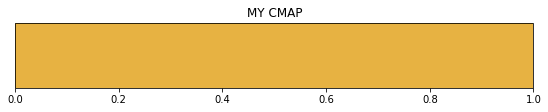

In [69]:
a = np.array([[0,1]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap=my_cmap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
plt.title("MY CMAP")

## Plot known cmap for comparison

Text(0.5, 1.0, 'JET')

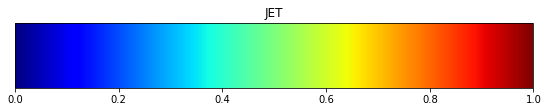

In [51]:
a = np.array([[0,1]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap="jet")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", cax=cax)
plt.title("JET")

# Calculate rough comparison between the two cmaps (euclidian distance)

#### Samples collected uniformly (np.linspace(0,1,n))

## Shown in "colorspace" coordinates (RGB)

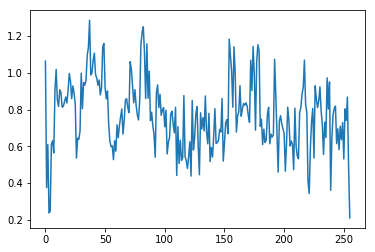

In [30]:
plt.plot(np.sum((plt.cm.jet(np.linspace(0,1,256))[..., :-1] - my_cmap(np.linspace(0,1,256))[..., :-1])**2, axis=1)**0.5)